# 3.4 Comparison of ML model and OGGM, PYGEM, GLOGEM on seasonal and annual glacier-wide mass balance

In [1]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import product
import dill as pickle
import xarray as xr
import seaborn as sns
from scipy.stats import gaussian_kde

import seaborn as sns
import matplotlib.lines as mlines
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

#from plotting_functions import plot_prediction_per_fold
from scripts.plotting_functions import plot_prediction
from scripts.plotting_functions import plot_gsearch_results

In [3]:
# Glaciological glacier-wide mass balances for glaciers in Norway
filepath_obs = 'C:/Users/kasj/ML_MB_Norway/src/Data/NVE_gw_mb/massbalance_gw_Norway.csv'
df_obs = pd.read_csv(filepath_obs, sep=';')
df_obs

,Year,RGIID,BREID,DateMinPrevYear,DateMax,DateMin,Area,Bw,Bs,Ba,Bcalv
0,1978,NaN,26,NaN,01.05.1978,01.10.1978,2.730,2.30,-2.40,-0.10,NaN
1,1979,NaN,26,01.10.1978,01.05.1979,NaN,2.730,2.10,NaN,NaN,NaN
2,1989,RGI60-08.01258,54,NaN,24.05.1989,19.10.1989,3.621,2.38,-2.98,-0.60,NaN
3,1990,RGI60-08.01258,54,19.10.1989,24.05.1990,05.09.1990,3.621,2.60,-2.98,-0.38,NaN
4,1991,RGI60-08.01258,54,05.09.1990,14.05.1991,04.10.1991,3.621,2.25,-2.29,-0.04,NaN
...,...,...,...,...,...,...,...,...,...,...,...
759,2013,RGI60-08.02969,3141,12.10.2012,29.05.2013,24.09.2013,22.541,2.49,-3.29,-0.80,NaN
760,2014,RGI60-08.02969,3141,24.09.2013,24.04.2014,14.10.2014,22.541,2.94,-3.68,-0.74,NaN
761,2015,RGI60-08.02969,3141,14.10.2014,22.04.2015,14.10.2015,22.541,2.90,-1.54,1.36,NaN
762,2016,RGI60-08.02969,3141,14.10.2015,28.04.2016,06.10.2016,22.539,2.92,-2.85,0.07,NaN


In [4]:
# Read dataframes of monthly predictions into test and train dataframes with all data
filepath_pred = 'C:/Users/kasj/ML_MB_Norway/src/Data/glacier_predictions/with_predictions_2024-10-24_10-30-28/all_glaciers_predictions.csv'
df_pred = pd.read_csv(filepath_pred)
df_pred = df_pred.rename(columns={'year':'Year','Ba_pred':'Ba','Bs_pred':'Bs','Bw_pred':'Bw'})
df_pred

,Year,Ba,Bw,Bs,BREID,RGIID
0,1960,-2.265225,0.996609,-3.261834,2320,RGI60-08.00434
1,1961,-0.535623,1.859654,-2.395276,2320,RGI60-08.00434
2,1962,0.302735,2.043542,-1.740807,2320,RGI60-08.00434
3,1963,-1.232353,1.617872,-2.850224,2320,RGI60-08.00434
4,1964,0.193896,1.983943,-1.790047,2320,RGI60-08.00434
...,...,...,...,...,...,...
1979,2017,-0.648707,2.511671,-3.160377,3126,RGI60-08.02966
1980,2018,-0.736439,3.026457,-3.762896,3126,RGI60-08.02966
1981,2019,-1.602043,2.087350,-3.689393,3126,RGI60-08.02966
1982,2020,0.526901,3.682097,-3.155196,3126,RGI60-08.02966


In [5]:
# Read glacier-wide predictiosn per model
filepath_glogem = 'C:/Users/kasj/ML_MB_Norway/src/Data/data_model_comparison/GLOGEM_annual_seasonal_glacier_wide.csv'
df_glogem = pd.read_csv(filepath_glogem)
df_glogem = df_glogem.rename(columns={'ID':'RGIID'})
df_glogem

,RGIID,Year,Ba,Bw,Bs
0,RGI60-08.02650,1980,-1.2965,2.1336,-3.4301
1,RGI60-08.02650,1981,1.0601,3.4973,-2.4372
2,RGI60-08.02650,1982,0.3777,2.7355,-2.3578
3,RGI60-08.02650,1983,1.0841,3.2312,-2.1471
4,RGI60-08.02650,1984,1.1511,3.6574,-2.5063
...,...,...,...,...,...
1275,RGI60-08.01258,2015,-0.8784,1.4670,-2.3454
1276,RGI60-08.01258,2016,-1.7201,1.4397,-3.1598
1277,RGI60-08.01258,2017,-0.1964,1.6806,-1.8770
1278,RGI60-08.01258,2018,-1.8513,1.3354,-3.1867


In [6]:
# Read glacier-wide predictiosn per model
filepath_oggm = 'C:/Users/kasj/ML_MB_Norway/src/Data/data_model_comparison/OGGM_annual_seasonal_glacier_wide.csv'
df_oggm = pd.read_csv(filepath_oggm)
df_oggm = df_oggm.rename(columns={'year':'Year'})
df_oggm

,Year,Ba,Bw,Bs,RGIID
0,1961,-1.180584,2.169184,-3.349768,RGI60-08.00287
1,1962,-0.210309,1.555307,-1.765617,RGI60-08.00287
2,1963,-0.527644,3.222508,-3.750152,RGI60-08.00287
3,1964,2.180276,3.583699,-1.403423,RGI60-08.00287
4,1965,0.424091,2.985545,-2.561454,RGI60-08.00287
...,...,...,...,...,...
1883,2015,1.344163,3.653286,-2.309123,RGI60-08.02969
1884,2016,-0.570878,2.973452,-3.544329,RGI60-08.02969
1885,2017,-0.472488,2.358645,-2.831133,RGI60-08.02969
1886,2018,-0.988100,2.854169,-3.842269,RGI60-08.02969


In [7]:
# Read glacier-wide predictiosn per model
filepath_pygem = 'C:/Users/kasj/ML_MB_Norway/src/Data/data_model_comparison/PYGEM_annual_seasonal_glacier_wide.csv'
df_pygem = pd.read_csv(filepath_pygem)
df_pygem

,Year,RGIID,Ba,Bw,Bs
0,1961,RGI60-08.00287,1.590050,2.504335,-0.914285
1,1961,RGI60-08.00295,1.402142,2.998990,-1.596849
2,1961,RGI60-08.00434,1.146692,2.240468,-1.093776
3,1961,RGI60-08.00449,0.620259,1.219500,-0.599242
4,1961,RGI60-08.00868,0.985669,1.172228,-0.186559
...,...,...,...,...,...
1979,2022,RGI60-08.02920,0.234622,3.758431,-3.523809
1980,2022,RGI60-08.02962,0.118508,3.815482,-3.696974
1981,2022,RGI60-08.02963,0.137094,3.666155,-3.529061
1982,2022,RGI60-08.02966,0.357176,3.751575,-3.394399


## Metrics and plots

Mass Balance Machine - Ba: RMSE=0.54, MSE=0.29, MAE=0.44, Bias=-0.12, R²=0.75, Count=182
Mass Balance Machine - Bw: RMSE=0.39, MSE=0.15, MAE=0.32, Bias=0.03, R²=0.84, Count=182
Mass Balance Machine - Bs: RMSE=0.55, MSE=0.30, MAE=0.45, Bias=-0.16, R²=0.73, Count=182
OGGM - Ba: RMSE=0.58, MSE=0.34, MAE=0.45, Bias=0.02, R²=0.71, Count=182
OGGM - Bw: RMSE=0.67, MSE=0.45, MAE=0.49, Bias=0.25, R²=0.53, Count=182
OGGM - Bs: RMSE=0.70, MSE=0.49, MAE=0.56, Bias=-0.24, R²=0.56, Count=182
GloGEM - Ba: RMSE=0.56, MSE=0.31, MAE=0.44, Bias=0.20, R²=0.73, Count=182
GloGEM - Bw: RMSE=0.42, MSE=0.18, MAE=0.31, Bias=-0.23, R²=0.81, Count=182
GloGEM - Bs: RMSE=0.71, MSE=0.50, MAE=0.55, Bias=0.43, R²=0.55, Count=182
PyGEM - Ba: RMSE=0.66, MSE=0.44, MAE=0.49, Bias=0.28, R²=0.62, Count=182
PyGEM - Bw: RMSE=0.72, MSE=0.52, MAE=0.58, Bias=0.50, R²=0.45, Count=182
PyGEM - Bs: RMSE=0.73, MSE=0.53, MAE=0.59, Bias=-0.22, R²=0.53, Count=182


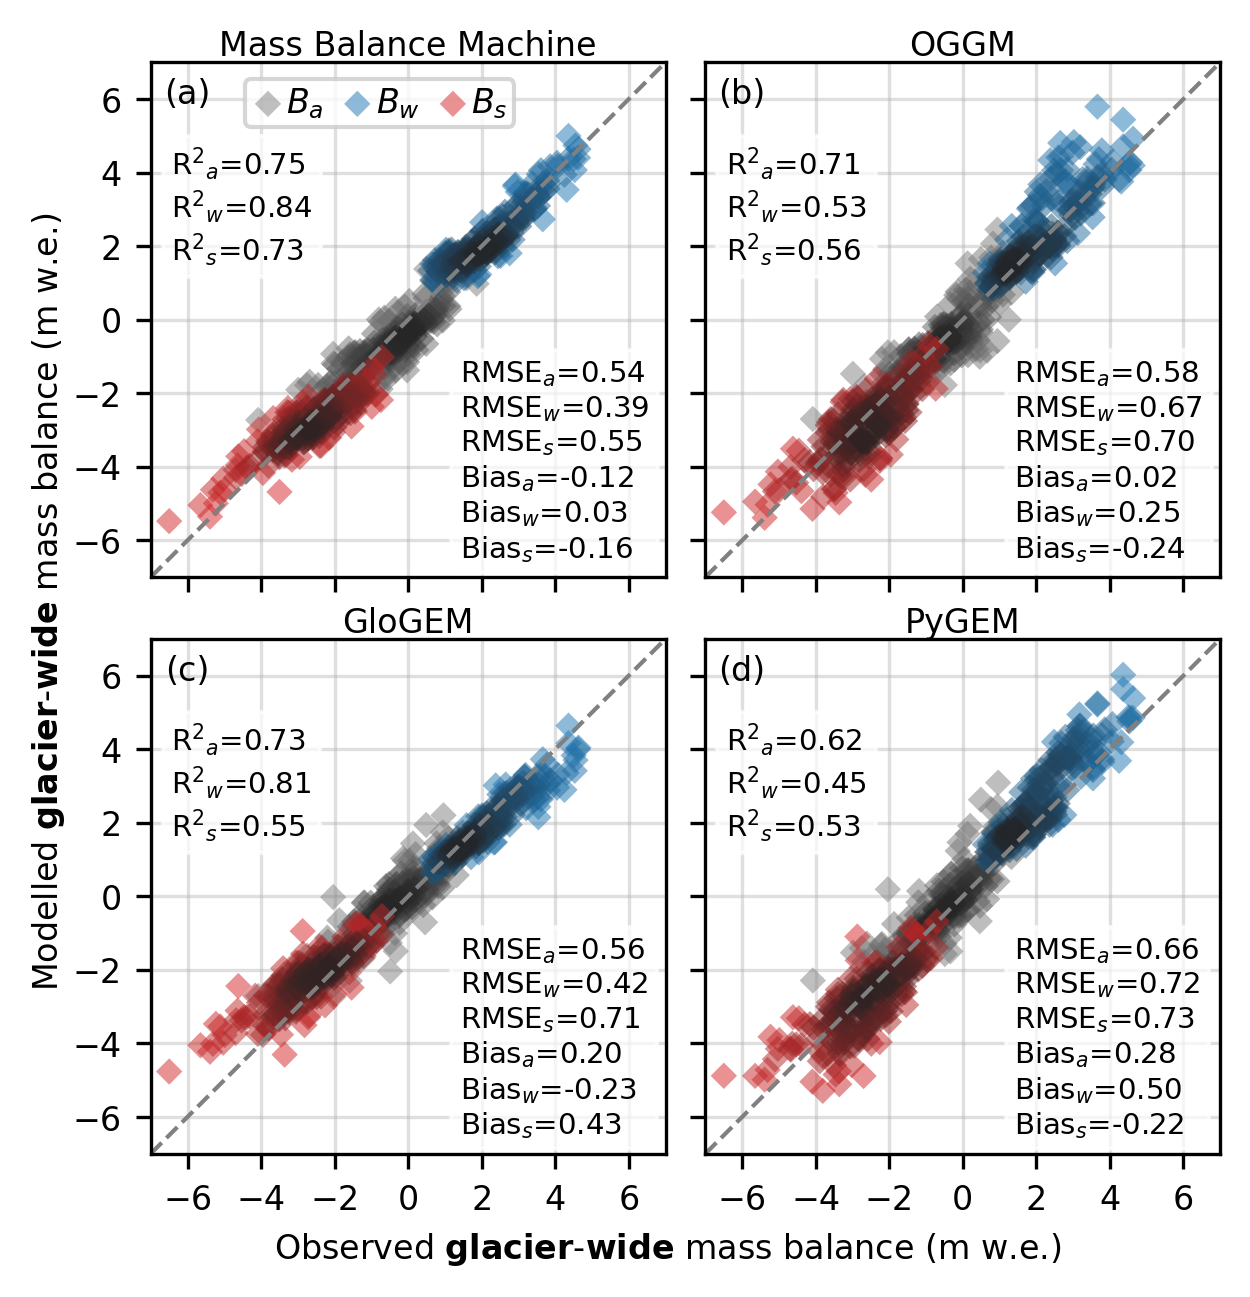

In [9]:
# PLOT POINTS WITH GAUSSIAN KDE (WORKS ONLY FOR COMMON TIME PERIOD DUE TO SORTING)

test_glaciers = ['00434', '00449', '01013', '01026', '01258', '01286', '01484', '01598', '02384', '02650', '02916', '02918', '02920', '02969']
train_glaciers = ['00287','00295','00868','00966','00987','01126','01186','01217','01657','01779','02017','02436','02458','02643','02666','02962','02963','02966']
all_glaciers = test_glaciers + train_glaciers

# Set the start and end years for the filter
start_year = 1980
end_year = 2019

gl = 'test'

# Function to filter based on RGIID ending and year range
def filter_df_by_rgiid_and_year(df, test_glaciers, start_year, end_year):
    return df[df['RGIID'].str.endswith(tuple(test_glaciers)) & (df['Year'] >= start_year) & (df['Year'] <= end_year)]

df_obs_nonan = df_obs.dropna(subset=['RGIID'])
if gl == 'test':
    df_obs_nonan = filter_df_by_rgiid_and_year(df_obs_nonan, test_glaciers, start_year, end_year)
    df_pred_filtered = filter_df_by_rgiid_and_year(df_pred, test_glaciers, start_year, end_year)
    df_oggm_filtered = filter_df_by_rgiid_and_year(df_oggm, test_glaciers, start_year, end_year)
    df_glogem_filtered = filter_df_by_rgiid_and_year(df_glogem, test_glaciers, start_year, end_year)
    df_pygem_filtered = filter_df_by_rgiid_and_year(df_pygem, test_glaciers, start_year, end_year)
elif gl == 'all':
    df_obs_nonan = filter_df_by_rgiid_and_year(df_obs_nonan, all_glaciers, start_year, end_year)
    df_pred_filtered = filter_df_by_rgiid_and_year(df_pred, all_glaciers, start_year, end_year)
    df_oggm_filtered = filter_df_by_rgiid_and_year(df_oggm, all_glaciers, start_year, end_year)
    df_glogem_filtered = filter_df_by_rgiid_and_year(df_glogem, all_glaciers, start_year, end_year)
    df_pygem_filtered = filter_df_by_rgiid_and_year(df_pygem, all_glaciers, start_year, end_year)

models = [(df_pred_filtered, 'Mass Balance Machine'), (df_oggm_filtered, 'OGGM'), (df_glogem_filtered, 'GloGEM'), (df_pygem_filtered, 'PyGEM')]

merged_dfs = [(df_obs_nonan.merge(model, how='inner', on=['RGIID', 'Year']), label) for model, label in models]

# Calculate RMSE, MSE, and bias
metrics = {}
valid_dfs = {}

for df, label in merged_dfs:
    metrics[label] = {}
    valid_dfs[label] = {}

    for metric in ['Ba', 'Bw', 'Bs']:
        df_metric = df.dropna(subset=[f'{metric}_x', f'{metric}_y'])
        observed = df_metric[f'{metric}_x']
        modeled = df_metric[f'{metric}_y']
        rmse = root_mean_squared_error(observed, modeled)
        mse = mean_squared_error(observed, modeled)
        bias = np.mean(modeled - observed)
        mae = np.mean(abs(modeled - observed))
        count = len(df_metric)  # Count valid pairs
        r2 = r2_score(observed, modeled) 
        
        metrics[label][metric] = {'rmse': rmse, 'mse': mse, 'mae': mae, 'bias': bias, 'r2':r2, 'count': count}
        valid_dfs[label][metric] = df_metric

        print(f'{label} - {metric}: RMSE={rmse:.2f}, MSE={mse:.2f}, MAE={mae:.2f}, Bias={bias:.2f}, R²={r2:.2f}, Count={count}')

def gaussian_kde_plot(x_,y_):
    xy = np.vstack([x_,y_])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x_[idx], y_[idx], z[idx]
    return x, y, z

from matplotlib.colors import ListedColormap
my_cmap_blue = sns.dark_palette('tab:blue', n_colors=8, as_cmap=True, reverse=True)
my_cmap_red = sns.dark_palette('tab:red', n_colors=8, as_cmap=True, reverse=True)
my_cmap_black = sns.dark_palette('grey', n_colors=8, as_cmap=True, reverse=True)
my_alpha = 0.5

cm=1/2.54
fontsize = 8
fontsize_small = 8.0
fontsize_min = 8.0
markersize = 20
subplot_labels = ['(a)', '(b)', '(c)', '(d)']
marker='D'
        
fig, axs = plt.subplots(2, 2, figsize=(12*cm, 12*cm), sharex=True, sharey=True, dpi=300)
axs = axs.flatten()

combined_min = min(df_obs[['Ba', 'Bw', 'Bs']].min().min(), df_pred[['Ba', 'Bw', 'Bs']].min().min(), 
                   df_oggm[['Ba', 'Bw', 'Bs']].min().min(), df_glogem[['Ba', 'Bw', 'Bs']].min().min(),
                   df_pygem[['Ba', 'Bw', 'Bs']].min().min())

combined_max = max(df_obs[['Ba', 'Bw', 'Bs']].max().max(), df_pred[['Ba', 'Bw', 'Bs']].max().max(), 
                   df_oggm[['Ba', 'Bw', 'Bs']].max().max(), df_glogem[['Ba', 'Bw', 'Bs']].max().max(),
                   df_pygem[['Ba', 'Bw', 'Bs']].max().max())

tick_min = np.floor(combined_min - 0.5)
tick_max = np.ceil(combined_max + 0.5)
ticks = np.arange(tick_min+1, tick_max-1, 2)

for idx, (df, label) in enumerate(merged_dfs):
    ax = axs[idx]
    
    for metric in ['Ba', 'Bw', 'Bs']:
        
        data = valid_dfs[label][metric]
        x_, y_ = data[f'{metric}_x'], data[f'{metric}_y']        
        x, y, z = gaussian_kde_plot(x_, y_)
        if metric == 'Ba':
            ax.scatter(x, y, c=z, marker=marker, s=markersize, edgecolors='none', cmap=my_cmap_black, alpha=my_alpha, label=metric)
        elif metric == 'Bw':
            ax.scatter(x, y, c=z, marker=marker, s=markersize, edgecolors='none', cmap=my_cmap_blue, alpha=my_alpha, label=metric)
        elif metric == 'Bs':
            ax.scatter(x, y, c=z, marker=marker, s=markersize, edgecolors='none', cmap=my_cmap_red, alpha=my_alpha, label=metric)

        #sns.scatterplot(x=f'{metric}_x', y=f'{metric}_y', data=valid_dfs[label][metric], ax=ax, label=metric,
        #                color=colors[metric], 
        #                #edgecolor=colors[metric], facecolor='none'
        #                )    
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='--', color='gray', linewidth=1)
    ax.set_xlabel('Observed glacier-wide mass balance (m w.e.)', fontsize=fontsize)
    ax.set_ylabel('Modeled glacier-wide mass balance (m w.e.)', fontsize=fontsize)
    ax.set_title(f'{label}', fontsize=fontsize, pad=0.1)
    ax.set_aspect('equal', 'box')
    ax.set_xlim(-7.0, 7.0)
    ax.set_ylim(-7.0, 7.0)
    ax.legend(loc = 'lower right', fontsize=fontsize)

    # Set the same ticks for x and y axes
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    ax.annotate(subplot_labels[idx], xy=(0.07, 0.97), xycoords='axes fraction', fontsize=fontsize_small,# fontweight='bold',
                ha='center', va='top')
    # Annotate with RMSE, MSE, Bias, and Count
    #textstr = '\n'.join([
        #f"{metric}: RMSE={metrics[label][metric]['rmse']:.2f}, MSE={metrics[label][metric]['mse']:.2f}, Bias={metrics[label][metric]['bias']:.2f}, Count={metrics[label][metric]['count']}"
        #f"{metric}: RMSE={metrics[label][metric]['rmse']:.2f} \n Bias={metrics[label][metric]['bias']:.2f}"
    #    f"RMSE$_{{{metric[-1]}}}$={metrics[label][metric]['rmse']:.2f}\n Bias$_{{{metric[-1]}}}$={metrics[label][metric]['bias']:.2f}"
    #    for metric in ['Ba', 'Bw', 'Bs']
    #])

    ax.set_axisbelow(True)
    ax.grid(alpha=0.4)
    
    rmse_list = [f"RMSE$_{{{metric[-1]}}}$={metrics[label][metric]['rmse']:.2f}" for metric in ['Ba', 'Bw', 'Bs']]
    mbe_list = [f"Bias$_{{{metric[-1]}}}$={metrics[label][metric]['bias']:.2f}" for metric in ['Ba', 'Bw', 'Bs']]
    textstr = '\n'.join(rmse_list + mbe_list)

    r2_list = [f"R$^2$$_{{{metric[-1]}}}$={metrics[label][metric]['r2']:.2f}" for metric in ['Ba', 'Bw', 'Bs']]
    textstr2 = '\n'.join(r2_list)

    ax.text(0.6, 0.025, textstr, transform=ax.transAxes, fontsize=7, #wrap=True,
            verticalalignment='bottom', bbox=dict(boxstyle='square', color='white', alpha=0.7))
    
    ax.text(0.04, 0.6, textstr2, transform=ax.transAxes, fontsize=7, #wrap=True,
            verticalalignment='bottom', bbox=dict(boxstyle='square', color='white', alpha=0.7))
    
    ax.legend().remove()

    ax.tick_params(axis='both', which='major', labelsize=fontsize_small)

for ax in axs:
    ax.set_xlabel('')
    ax.set_ylabel('')

axs[0].legend(['$B_{a}$','$B_{w}$','$B_{s}$'],loc = 'upper left', fontsize=fontsize_small, 
              handlelength= 1, handletextpad=0.05,borderpad=0.2,labelspacing=0.2, ncols=3, columnspacing=0.5, bbox_to_anchor=(0.15,1.0))
    
for idx in range(len(merged_dfs), len(axs)):
    fig.delaxes(axs[idx])

fig.supxlabel('Observed $\mathbf{glacier}$-$\mathbf{wide}$ mass balance (m w.e.)', fontsize=fontsize, y=0.03)#, labelpad = 16)
fig.supylabel('Modelled $\mathbf{glacier}$-$\mathbf{wide}$ mass balance (m w.e.)', fontsize=fontsize, x=0.05)#, labelpad = 16)

plt.subplots_adjust(wspace=0.02, hspace=0.12)
#plt.tight_layout()

#pdf_path = 'C:/Users/kasj/OneDrive - Høgskulen på Vestlandet/Projects/2022_ML_for_MB_Norway/Figures_paper/'
#plt.savefig(pdf_path+'comparison_glacier_wide_test_common_obs_kde.pdf', format='pdf', bbox_inches='tight')

plt.show()

